# Excited States via EOM-QSE (Operator-Manifold Commutator EOM)

This notebook validates that:
- A reference ground-state VQE run produces a noiseless statevector |ψ⟩ and energy E0
- EOM-QSE builds the **commutator EOM** generalized eigenproblem in an operator manifold:

  $$
    A_{ij} = \langle \psi | O_i^\dagger [H, O_j] | \psi \rangle,\quad
    S_{ij} = \langle \psi | O_i^\dagger O_j | \psi \rangle
  $$

- It solves $ A c = \omega S c $ (generally non-Hermitian) and returns:
  - excitation energies ω (positive, “real-ish” roots)
  - excited energies E0 + ω

It prints:
- Lowest exact eigenvalues of a reference Hamiltonian
- Reference VQE energy E0
- EOM-QSE excitation energies ω_i and excited energies E0 + ω_i
- |ΔE| vs nearest exact eigenvalue (loose sanity)
- Diagnostics: overlap spectrum, kept rank, complex/real-ish root counts

In [1]:
import numpy as np
import pennylane as qml
from pennylane import qchem

from vqe.eom_qse import run_eom_qse
from vqe.visualize import plot_eom_qse_spectrum

## Configuration

In [2]:
molecule = "H2"
k = 4

ansatz_name = "UCCSD"
optimizer_name = "Adam"
steps = 80
stepsize = 0.2
seed = 0
mapping = "jordan_wigner"

pool = "hamiltonian_topk"
max_ops = 24

eps = 1e-10
imag_tol = 1e-10
omega_eps = 1e-12

force = False

## Exact spectrum benchmark (reference Hamiltonian)

In [3]:
sym = ["H", "H"]
coords = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ],
    dtype=float,
)
basis = "sto-3g"

H_ref, n_wires = qchem.molecular_hamiltonian(sym, coords, basis=basis, unit="Angstrom")

Hmat = np.array(qml.matrix(H_ref), dtype=complex)
exact_evals = np.sort(np.linalg.eigvalsh(Hmat).real)

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print(f"Lowest {max(10, k)} exact eigenvalues (Ha):")
for i, e in enumerate(exact_evals[: max(10, k)]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    sto-3g
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


## Helpers

In [4]:
def _nearest_exact_energy(E: float, exact: np.ndarray) -> tuple[float, float, int]:
    diffs = np.abs(exact - float(E))
    j = int(np.argmin(diffs))
    return float(exact[j]), float(diffs[j]), j


def summarize_eom_qse(result: dict, exact: np.ndarray, *, label: str) -> None:
    E0 = float(result["reference_energy"])
    omegas = np.array(result["excitations"], dtype=float)
    energies = np.array(result["eigenvalues"], dtype=float)

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)
    print(f"E0 (reference): {E0:+.10f} Ha")
    print(f"num_qubits:     {int(result['num_qubits'])}")
    print()

    for i, (w, E) in enumerate(zip(omegas, energies)):
        target, err, j = _nearest_exact_energy(float(E), exact)
        print(
            f"root {i:>2}:  ω = {float(w):+.10f} Ha   "
            f"E = E0+ω = {float(E):+.10f} Ha   "
            f"nearest exact[{j}] = {target:+.10f} Ha   |ΔE| = {err:.3e} Ha"
        )

## EOM-QSE (operator-manifold commutator EOM)

In [5]:
eom_qse_res = run_eom_qse(
    molecule=molecule,
    k=k,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    mapping=mapping,
    pool=pool,
    max_ops=max_ops,
    eps=eps,
    imag_tol=imag_tol,
    omega_eps=omega_eps,
    force=force,
)

Step 01/80: E = -1.116684 Ha
Step 02/80: E = -1.136994 Ha
Step 03/80: E = -1.131007 Ha
Step 04/80: E = -1.122700 Ha
Step 05/80: E = -1.130115 Ha
Step 06/80: E = -1.133031 Ha
Step 07/80: E = -1.134496 Ha
Step 08/80: E = -1.134652 Ha
Step 09/80: E = -1.132102 Ha
Step 10/80: E = -1.130839 Ha
Step 11/80: E = -1.133769 Ha
Step 12/80: E = -1.136856 Ha
Step 13/80: E = -1.136817 Ha
Step 14/80: E = -1.134837 Ha
Step 15/80: E = -1.133732 Ha
Step 16/80: E = -1.134458 Ha
Step 17/80: E = -1.135957 Ha
Step 18/80: E = -1.136742 Ha
Step 19/80: E = -1.136508 Ha
Step 20/80: E = -1.136055 Ha
Step 21/80: E = -1.135899 Ha
Step 22/80: E = -1.135938 Ha
Step 23/80: E = -1.136174 Ha
Step 24/80: E = -1.136688 Ha
Step 25/80: E = -1.137068 Ha
Step 26/80: E = -1.136886 Ha
Step 27/80: E = -1.136406 Ha
Step 28/80: E = -1.136270 Ha
Step 29/80: E = -1.136684 Ha
Step 30/80: E = -1.137181 Ha
Step 31/80: E = -1.137213 Ha
Step 32/80: E = -1.136850 Ha
Step 33/80: E = -1.136654 Ha
Step 34/80: E = -1.136858 Ha
Step 35/80: E 

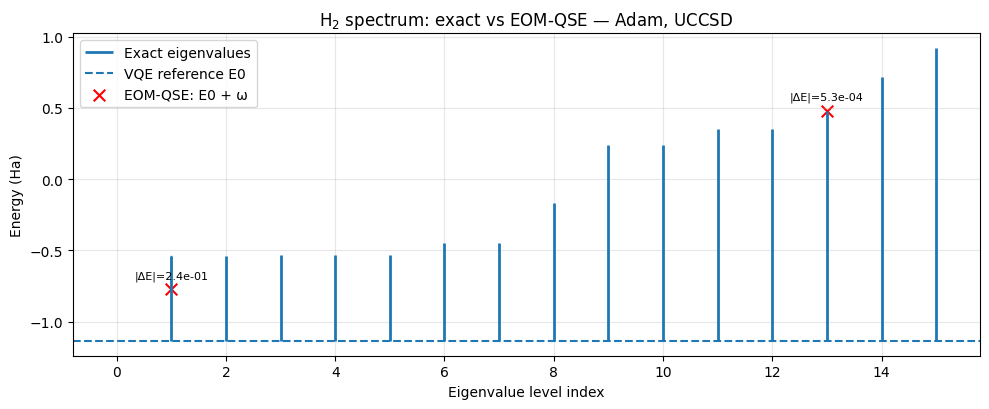

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/eom_qse_spectrum_UCCSD_Adam_s0.png


In [6]:
plot_eom_qse_spectrum(
    exact_evals,
    eom_qse_res,
    molecule_label=molecule,
    show=True,
    save=True,
)

## Summary table

In [7]:
summarize_eom_qse(
    eom_qse_res,
    exact_evals,
    label="Noiseless EOM-QSE (operator-manifold commutator EOM)",
)


Noiseless EOM-QSE (operator-manifold commutator EOM)
E0 (reference): -1.1372694521 Ha
num_qubits:     4

root  0:  ω = +0.3625776153 Ha   E = E0+ω = -0.7746918368 Ha   nearest exact[1] = -0.5387095807 Ha   |ΔE| = 2.360e-01 Ha
root  1:  ω = +1.6176359359 Ha   E = E0+ω = +0.4803664838 Ha   nearest exact[13] = +0.4798361027 Ha   |ΔE| = 5.304e-04 Ha


## Diagnostics: overlap spectrum and eigenvalue filtering

In [8]:
diag = eom_qse_res.get("diagnostics", {})

S_eigs = diag.get("S_eigs", [])
print("Overlap eigenvalues (S):")
for i, x in enumerate(S_eigs):
    print(f"  s[{i:>2}] = {float(x): .6e}")

print()
print(f"subspace_dim:            {diag.get('subspace_dim', None)}")
print(f"kept_rank:               {diag.get('kept_rank', None)}")
print(f"eps:                     {diag.get('eps', None)}")
print(f"imag_tol:                {diag.get('imag_tol', None)}")
print(f"omega_eps:               {diag.get('omega_eps', None)}")
print(f"S_condition_kept:        {diag.get('S_condition_kept', None)}")
print()

print("Reduced-space eigenvalue stats:")
print(f"  num_eigs_total_reduced:        {diag.get('num_eigs_total_reduced', None)}")
print(f"  num_eigs_realish:              {diag.get('num_eigs_realish', None)}")
print(f"  num_eigs_positive_realish:     {diag.get('num_eigs_positive_realish', None)}")
print(f"  min_real_part:                 {diag.get('min_real_part', None)}")
print(f"  max_real_part:                 {diag.get('max_real_part', None)}")
print(f"  max_abs_imag_part:             {diag.get('max_abs_imag_part', None)}")

Overlap eigenvalues (S):
  s[ 0] = -1.939831e-15
  s[ 1] = -6.673648e-17
  s[ 2] = -8.713472e-18
  s[ 3] = -1.383362e-18
  s[ 4] = -5.666248e-28
  s[ 5] = -1.024427e-43
  s[ 6] =  1.500281e-29
  s[ 7] =  2.635174e-28
  s[ 8] =  6.023328e-17
  s[ 9] =  4.585653e-16
  s[10] =  9.635151e-16
  s[11] =  1.077975e-05
  s[12] =  1.939095e-05
  s[13] =  3.999999e+00
  s[14] =  1.099997e+01

subspace_dim:            15
kept_rank:               4
eps:                     1e-10
imag_tol:                1e-10
omega_eps:               1e-12
S_condition_kept:        1020429.0829320844

Reduced-space eigenvalue stats:
  num_eigs_total_reduced:        4
  num_eigs_realish:              4
  num_eigs_positive_realish:     2
  min_real_part:                 -6.770013766819303e-20
  max_real_part:                 1.6176359359408636
  max_abs_imag_part:             0.0


## Operator pool summary (first few operators)

In [9]:
cfg = eom_qse_res.get("config", {})
ops = cfg.get("eom_qse_ops", [])

print(f"Pool:    {cfg.get('eom_qse_pool', None)}")
print(f"max_ops: {cfg.get('eom_qse_max_ops', None)}")
print(f"n_ops (actual): {len(ops)}")
print()

print("First few operator specs:")
for i, spec in enumerate(ops[: min(10, len(ops))]):
    print(f"  #{i:>2}: {spec}")

Pool:    hamiltonian_topk
max_ops: 24
n_ops (actual): 15

First few operator specs:
  # 0: {'type': 'pauli_word', 'word': 'IIII', 'wires': [0, 1, 2, 3]}
  # 1: {'type': 'pauli_word', 'word': 'Z', 'wires': [2]}
  # 2: {'type': 'pauli_word', 'word': 'Z', 'wires': [3]}
  # 3: {'type': 'pauli_word', 'word': 'ZZ', 'wires': [2, 3]}
  # 4: {'type': 'pauli_word', 'word': 'Z', 'wires': [0]}
  # 5: {'type': 'pauli_word', 'word': 'Z', 'wires': [1]}
  # 6: {'type': 'pauli_word', 'word': 'ZZ', 'wires': [0, 1]}
  # 7: {'type': 'pauli_word', 'word': 'ZZ', 'wires': [1, 2]}
  # 8: {'type': 'pauli_word', 'word': 'ZZ', 'wires': [0, 3]}
  # 9: {'type': 'pauli_word', 'word': 'ZZ', 'wires': [0, 2]}
